In [1]:
import numpy as np
import skimage.io
import skimage.draw
import json
from skimage.draw import polygon
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

# Extracting masks from json files

## Code for lung and collarbone mask

In [6]:
df_lmask=[]
def funmask(data,image,num):
  id=str(num)+'.png'
  x1=[data['_via_img_metadata'][id]['regions'][1]['shape_attributes']['all_points_x']]
  y1=[data['_via_img_metadata'][id]['regions'][1]['shape_attributes']['all_points_y']]
  x2=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_x']]
  y2=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_y']]
  poly=[]
  for i in range(len(x2[0])):
    poly.append((x2[0][i],y2[0][i]))
  poly.append((x2[0][0],y2[0][0]))
  for i in range(len(x1[0])):
    poly.append((x1[0][i],y1[0][i]))
  poly.append((x1[0][0],y1[0][0]))
  poly=np.array(poly) 
  mask = np.ones(shape=image.shape[0:2] ,dtype="bool")
  rr, cc = polygon(poly[:, 1], poly[:, 0], image.shape)
  mask[rr,cc]=0
  image[mask]=0
  df_lmask.append(resize(mask,(IMG_HEIGHT,IMG_WIDTH,1)))

## Code for heart and trachea mask

In [3]:
df_lmask=[]
def funmask(data,image,num):
  id=str(num)+'.png'
  x1=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_x']]
  y1=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_y']]
  poly=[]
  for i in range(len(x1[0])):
    poly.append((x1[0][i],y1[0][i]))
  poly.append((x1[0][0],y1[0][0]))
  poly=np.array(poly) 
  mask = np.ones(shape=image.shape[0:2] ,dtype="bool")
  rr, cc = polygon(poly[:, 1], poly[:, 0], image.shape)
  mask[rr,cc]=0
  image[mask]=0
  df_lmask.append(resize(mask,(IMG_HEIGHT,IMG_WIDTH)))

In [4]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3
image_path="C:\\Users\\Admin\\Documents\\Data\\images\\"
mask_path="C:\\Users\\Admin\\Documents\\Data\\mask_cbone\\"

In [7]:
df_image=[]
for i in range(150):
    df_image.append(resize(skimage.io.imread(image_path+str(i+1)+'.png'),(128,128,3)))
df_lmask=[]
for i in range(150):
    image = skimage.io.imread("C:\\Users\\Admin\\Documents\\Data\\images\\1.png")
    f = open(mask_path+str(i+1)+'.json','r')
    data=json.load(f)
    funmask(data,image,i+1)

In [8]:
X=(np.array(df_image)).reshape((len(df_image),IMG_HEIGHT,IMG_WIDTH,3))
Y=(np.array(df_lmask)).reshape((len(df_lmask),IMG_HEIGHT,IMG_WIDTH,1))
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.20, random_state=42)

In [9]:
def g_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [10]:
def c_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [11]:
def attention_gate(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  

    upsample_psi = dup_axis(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [12]:
def dup_axis(tensor, rep):
   
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [13]:
def Attention_UWNet_v2(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)


    conv_128 = c_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    conv_64 = c_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    conv_32 = c_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    conv_16 = c_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    conv_8 = c_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    gatingw_16 = g_signal(conv_8, 8*FILTER_NUM, batch_norm)
    attw_16 = attention_gate(conv_16, gatingw_16, 8*FILTER_NUM)
    upw_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    upw_16 = layers.concatenate([upw_16, attw_16], axis=3)
    up_convw_16 = c_block(upw_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    conv_down_8=tf.keras.layers.Conv2D(256,(3,3),strides=(2,2), activation = 'relu', padding='same')(up_convw_16)
    convw_8 = c_block(conv_down_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    
    gating_16 = g_signal(convw_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_gate(up_convw_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(convw_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = c_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    gating_32 = g_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_gate(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = c_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    gating_64 = g_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_gate(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = c_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    
    gating_128 = g_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_gate(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = c_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UWNet")
    return model

In [14]:
from tensorflow.keras import backend as K

ra_unet=Attention_UWNet_v2((128,128,3),dropout_rate=0.0, batch_norm=True)
ra_unet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
results=ra_unet.fit(x_train,y_train,validation_data=(x_val, y_val),batch_size=8,epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 57ms/step - loss: 0.3309 - accuracy: 0.9971 - val_loss: 0.3546 - val_accuracy: 0.9909
Epoch 2/50
15/15 [==============================] - 1s 49ms/step - loss: 0.3271 - accuracy: 0.9971 - val_loss: 0.3537 - val_accuracy: 0.9905
Epoch 3/50
15/15 [==============================] - 1s 48ms/step - loss: 0.3230 - accuracy: 0.9972 - val_loss: 0.3473 - val_accuracy: 0.9910
Epoch 4/50
15/15 [==============================] - 1s 49ms/step - loss: 0.3187 - accuracy: 0.9975 - val_loss: 0.3472 - val_accuracy: 0.9905
Epoch 5/50
15/15 [==============================] - 1s 49ms/step - loss: 0.3155 - accuracy: 0.9973 - val_loss: 0.3331 - val_accuracy: 0.9913
Epoch 6/50
15/15 [==============================] - 1s 48ms/step - loss: 0.3124 - accuracy: 0.9972 - val_loss: 0.3291 - val_accuracy: 0.9910
Epoch 7/50
15/15 [==============================] - 1s 49ms/step - loss: 0.3201 - accuracy: 0.9938 - val_loss: 0.9041 - val_accuracy: 0.5529
Epoch 8/50
15

1/1 [==============================] - 1s 1s/step


(-0.5, 127.5, 127.5, -0.5)

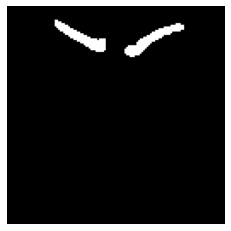

In [17]:
ima = resize(skimage.io.imread("C:\\Users\\Admin\\Documents\\Data\\Image.png"),(128,128,3))
ima=(1-(ra_unet.predict((ima).reshape(1,128,128,3),verbose=1))[0,:,:,0])
plt.imshow((ima>0.50).astype(np.uint8),cmap='gray')
plt.axis('off')